# Project 1 CNN --- test part

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Load data

In [2]:
normal_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])

test_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=normal_transform, download=False)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=normal_transform, download=False)

In [3]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=len(test_dataset),
                                          num_workers=2,
                                          shuffle=True)

test_train_loader = torch.utils.data.DataLoader(test_train_dataset,
                                                batch_size=len(test_train_dataset),
                                                num_workers=2)

torch.Size([10000, 1, 28, 28])


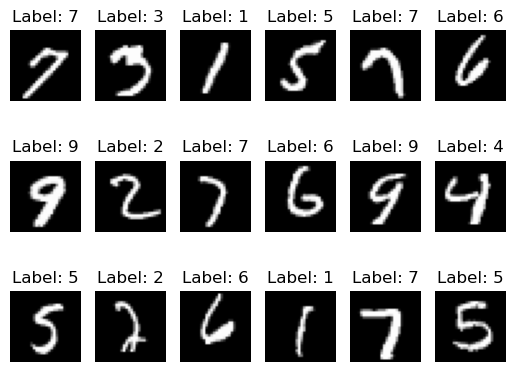

In [4]:
# Visualization of test dataset, see the augmentation
batch_idx, (data, target) = next(enumerate(test_loader, 0))
print(data.shape)

fig = plt.figure()
for i in range(18):
  plt.subplot(3, 6, i+1)
  plt.imshow(data[i][0], cmap='gray')
  plt.title('Label: {}'.format(target[i]))
  plt.axis(False)

## Load the model

In [5]:
# Traditional CNN
class Cnn_mnist(nn.Module):
    '''
    Convolution neural net work with 2 convolution layers and 2 fully connected layers.
    '''

    def __init__(self):
        super(Cnn_mnist, self).__init__()
        # Convolution layer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding='same')
        self.mp1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv1_drop = nn.Dropout2d(0.3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.mp2 = nn.MaxPool2d(4)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2_drop = nn.Dropout2d(0.3)

        # Fully connect layer
        self.fc1 = nn.Linear(1152, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp1(self.conv1_drop(self.bn1(self.conv1(x)))))
        x = F.relu(self.mp2(self.conv2_drop(self.bn2(self.conv2(x)))))
        x = x.view(in_size, -1)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
# Inception CNN
class Inception(nn.Module):
    '''
    Inception helper for building inception layer.
    Output channels: 88
    '''
    def __init__(self, in_channels):
        super(Inception, self).__init__()
        self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        
        self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)
        
        self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)
        
        self.branch3x3_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)
        
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
        
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3, branch_pool]
        return torch.cat(outputs, 1)

    
class Inception_mnist(nn.Module):
    '''
    Convolution neural network with 2 convolution layers connected with a inception layer.
    Two fully connected layers for output.
    '''
    def __init__(self):
        super(Inception_mnist, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        self.incept1 = Inception(in_channels=64)
        self.bn2 = nn.BatchNorm2d(88)
        self.conv2 = nn.Conv2d(88, 128, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        # self.incept2 = Inception(in_channels=128)
        # self.bn4 = nn.BatchNorm2d(88)
        
        self.mp = nn.MaxPool2d(2)
        self.conv_drop = nn.Dropout2d(0.3)
        
        self.fc1 = nn.Linear(6272, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv_drop(self.bn1(self.conv1(x)))))
        x = self.conv_drop(self.bn2(self.incept1(x)))
        x = F.relu(self.mp(self.bn3(self.conv_drop(self.conv2(x)))))
        # x = self.conv_drop(self.bn4(self.incept2(x)))
        x = x.view(in_size, -1)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [7]:
# Load the best parameters of model in training
cnn_model = Cnn_mnist()
cnn_model.load_state_dict(torch.load('./model/Classic_cnn.pth'))

incept_model = Inception_mnist()
incept_model.load_state_dict(torch.load('./model/Inception_cnn.pth'))


<All keys matched successfully>

## Evaluate the model

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    inputs, targets = next(iter(test_loader))
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    print('Performance: ')
    print(classification_report(targets, predicted))
    print('Confusion matrix:')
    print(confusion_matrix(targets, predicted))
    print('\nACCURACY: {}'.format(accuracy_score(targets, predicted)))


### Performance of classic CNN

In [9]:
# In test dataset
evaluate_model(model=cnn_model, test_loader=test_loader)

Performance: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      1.00       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       1.00      1.00      1.00      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

Confusion matrix:
[[ 978    0    0    0    0    0    2    0    0    0]
 [   0 1134    1    0    0    0    0    0    0    0]
 [   0    0 1028    0    0    0    0    3    1    0]
 [   0    0    0 1008    0    1    0    1    0    

### Performance of Inception CNN

In [10]:
# In test
evaluate_model(model=incept_model, test_loader=test_loader)

Performance: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       1.00      0.99      1.00       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      1.00       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       0.99      1.00      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

Confusion matrix:
[[ 979    0    0    0    0    0    1    0    0    0]
 [   0 1133    1    0    0    0    1    0    0    0]
 [   0    0 1031    0    0    0    0    1    0    0]
 [   0    0    0 1005    0    4    0    0    1    

### Ensembled CNN

In [48]:
def ensembled(model1, model2, loader):
    model1.eval()
    model2.eval()
    
    inputs, targets = next(iter(test_loader))
    outputs = 2*model1(inputs)/5 + 3*model2(inputs)/5
    _, predicted = torch.max(outputs, 1)

    print('Performance: ')
    print(classification_report(targets, predicted))
    print('Confusion matrix:')
    print(confusion_matrix(targets, predicted))
    print('\nACCURACY: {}'.format(accuracy_score(targets, predicted)))

In [49]:
ensembled(cnn_model, incept_model, test_loader)

Performance: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       1.00      1.00      1.00       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      1.00       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       1.00      1.00      1.00      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

Confusion matrix:
[[ 979    0    0    0    0    0    1    0    0    0]
 [   0 1133    1    0    0    0    1    0    0    0]
 [   0    0 1030    0    0    0    0    2    0    0]
 [   0    0    0 1008    0    2    0    0    0    